## Match NCES School Data to School Building Data

The National Center for Education Statistics provides annual data on schools (public, private, postsecondary) as well as key characteristics (staff and student counts).

This data can be matched to the nearest buildings identified as school buildings.


Based on help from:

https://osmnx.readthedocs.io/en/stable/osmnx.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.query.html

Goal is to accurately assign business information to buildings.


## Description of Program
- program:    IN-CORE_2bv1_MatchNCESSchoolBuilding
- task:       Match NCES point data to nearest building location
- Version:    2021-06-17
-             2021-06-18 - using pyincore_addons.geoutil_20210618.py
 -            2021-08-19 - update outputfolder - issue with file path greater than 260 characters
- project:    Interdependent Networked Community Resilience Modeling Environment (IN-CORE) Subtask 5.2 - Social Institutions
- funding:	  NIST Financial Assistance Award Numbers: 70NANB15H044 and 70NANB20H008 
- author:     Nathanael Rosenheim

- Suggested Citation:
Rosenheim, N. (2021) “Obtain, Clean, and Explore Labor Market Allocation Methods". 
Archived on Github and ICPSR.

In [1]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np  # group by aggregation
#import folium as fm # folium has more dynamic maps - but requires internet connection

In [2]:
# Display versions being used - important information for replication
import sys
print("Python Version     ", sys.version)
print("geopandas version: ", gpd.__version__)
print("pandas version:    ", pd.__version__)
print("numpy version:     ", np.__version__)
#print("folium version:    ", fm.__version__)

Python Version      3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 15:37:01) [MSC v.1916 64 bit (AMD64)]
geopandas version:  0.9.0
pandas version:     1.3.3
numpy version:      1.21.2


In [3]:
import os # For saving output to path
# Store Program Name for output files to have the same name
programname = "IN-CORE_2bv1_MatchNCESSchoolBuilding_2021-08-19"

# Save Outputfolder - due to long folder name paths output saved to folder with shorter name
# files from this program will be saved with the program name - this helps to follow the overall workflow
outputfolder = "workflow_output"
# Make directory to save output
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

# Setup access to IN-CORE
https://incore.ncsa.illinois.edu/

In [4]:
from pyincore import IncoreClient, Dataset, FragilityService, MappingSet, DataService
from pyincore_viz.geoutil import GeoUtil as viz

In [6]:
client = IncoreClient()
# IN-CORE chaches files on the local machine, it might be necessary to clear the memory
#client.clear_cache()

Enter username: mxa261
Enter password: ········
Connection successful to IN-CORE services. pyIncore version detected: 1.0.0


In [7]:
# create data_service object for loading files
#data_service = DataService(client)

### IN-CORE addons
This program uses coded that is being developed as potential add ons to pyincore. These functions are in a folder called pyincore_addons - this folder is located in the same directory as this notebook.
The add on functions are organized to mirror the folder sturcture of https://github.com/IN-CORE/pyincore

Each add on function attempts to follow the structure of existing pyincore functions and includes some help information.

In [8]:
# to access new package that is in a sibling folder - the system path list needs to inlcude the parent folder (..)
# append the path of the
# parent directory
sys.path.append("..")

In [9]:
# open, read, and execute python program with reusable commands
import pyincore_addons.geoutil_20210618 as add2incore

# since the geoutil is under construction it might need to be reloaded
from importlib import reload 
add2incore = reload(add2incore)

# Print list of add on functions
from inspect import getmembers, isfunction
print(getmembers(add2incore,isfunction))

[('df2gdf_WKTgeometry', <function df2gdf_WKTgeometry at 0x00000212644F1288>), ('nearest_pt_search', <function nearest_pt_search at 0x000002126B9AD708>)]


## Read in Building Data


In [10]:
sourceprogram = "IN-CORE_1gv1_SchoolBuildingData_2021-08-19"
filename = outputfolder+"/"+sourceprogram+".csv"
building_df = pd.read_csv(filename)

# Convert dataframe to gdf
building_gdf = add2incore.df2gdf_WKTgeometry(df = building_df, projection = "epsg:4326",reproject="epsg:26917")
building_gdf.head(2)

,Unnamed: 0,guid,strctid,ffe_elev,archetype,parid,struct_typ,no_stories,a_stories,b_stories,...,dwell_unit,str_typ2,occ_typ2,appr_bldg,appr_land,appr_tot,year_built,lhsm_elev,g_elev,geometry
0,2495,66b1392e-c7b0-4bd8-a092-a7ff0ea6c15a,ST66b1392e-c7b0-4bd8-a092-a7ff0ea6c15a,43.88056,10,3715519218,NaN,1,0,0,...,0,NaN,NaN,0,0,0,1978,0.0,43.2816,POINT (672189.465 3829164.868)
1,2496,31d34dad-4211-40d9-b4e3-38677b5ee72f,ST31d34dad-4211-40d9-b4e3-38677b5ee72f,43.86102,10,3715519217,NaN,1,0,0,...,0,NaN,NaN,0,0,0,1978,0.0,43.2816,POINT (672181.958 3829181.790)


In [11]:
help(viz.plot_gdf_map)

Help on function plot_gdf_map in module pyincore_viz.geoutil:

plot_gdf_map(gdf, column, category=False, basemap=True, source={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': '(C) OpenStreetMap contributors', 'name': 'OpenStreetMap.Mapnik'})
    Plot Geopandas DataFrame.
    
    Args:
        gdf (obj): Geopandas DataFrame object.
        column (str): A column name to be plot.
        category (bool): Turn on/off category option.
        basemap (bool): Turn on/off base map (e.g. openstreetmap).
        source(obj): source of the Map to be used. examples, ctx.providers.OpenStreetMap.Mapnik (default),
            ctx.providers.Stamen.Terrain, ctx.providers.CartoDB.Positron etc.



Map of school buildings 10 = One Story [84], 11 = Two Story [4]


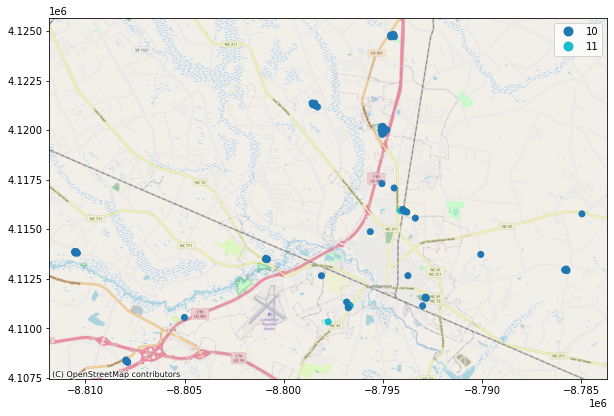

In [12]:
map = viz.plot_gdf_map(building_gdf,column='archetype', category=True)
print("Map of school buildings 10 = One Story [84], 11 = Two Story [4]")
map

In [13]:
building_gdf['guid'].describe()

count                                       88
unique                                      88
top       66b1392e-c7b0-4bd8-a092-a7ff0ea6c15a
freq                                         1
Name: guid, dtype: object

## Read in NCES School Data

In [14]:
sourcefolder = '../SourceData/nces_ed_gov/'
sourceprogram = "NCES_2bv1_AddTeacherCount_2021-06-15"
filename = sourcefolder+"/"+sourceprogram+"/"+sourceprogram+".csv"
school_df = pd.read_csv(filename)

# Convert dataframe to gdf
school_gdf = add2incore.df2gdf_WKTgeometry(df = school_df, projection = "epsg:4326",reproject="epsg:26917")
school_gdf.head()

FileNotFoundError: [Errno 2] No such file or directory: '../SourceData/nces_ed_gov//NCES_2bv1_AddTeacherCount_2021-06-15/NCES_2bv1_AddTeacherCount_2021-06-15.csv'

In [ ]:
map = viz.plot_gdf_map(school_gdf,column='schtype', category=True)
print("NCES School Data for Robeson County]")
map

In [ ]:
school_gdf['ncesid'].describe()

## Set up data for nearest neighbor search

Need to do this in the revese order as the businesses. For business there is one business location going to one building and one building could have multiple businesses...
In this case we want the one school id to go multiple nearby buildings.

## Run nearest neighbor algorithm

In [ ]:
help(add2incore.nearest_pt_search)

In [ ]:
buiding_nces_gdf = add2incore.nearest_pt_search(gdf_a = school_gdf,
                                               gdf_b = building_gdf,
                                               uniqueid_a = 'ncesid',
                                               uniqueid_b = 'guid',
                                               k = 6,
                                               dist_cutoff = 250)

In [ ]:
buiding_nces_gdf.head()

In [ ]:
buiding_nces_gdf[['neighbor','guid']].fillna('none').groupby(
    ['neighbor']).count()

In [ ]:
buiding_nces_gdf.guid.describe()

In [ ]:
# Save Work at this point as CSV
savefile = sys.path[0]+"/"+outputfolder+"/"+programname+".csv"
buiding_nces_gdf.to_csv(savefile)